# Causal effect estimation with `TIGRAMITE`

TIGRAMITE is a time series analysis python module. It allows to reconstruct graphical models (conditional independence graphs) from discrete or continuously-valued time series based on the PCMCI framework and create high-quality plots of the results. 

This tutorial explains the CausalEffects class from ``causal_effects.py`` which allows to estimate general linear and nonlinear (conditional) causal effects and mediation with optimal adjustment sets. The main background paper explaining optimal adjustment theory is:

J. Runge, Necessary and sufficient graphical conditions for optimal adjustment sets in causal graphical models with hidden variables, Advances in Neural Information Processing Systems, 2021, 34

__Importantly__, the CausalEffects class explicitely addresses not only time series, but also non-time series data.

In [1]:
# Imports

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')
from scipy.stats import gaussian_kde

import tigramite
from tigramite import data_processing as pp
from tigramite.toymodels import structural_causal_processes as toys
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, GPDC, CMIknn, CMIsymb
from tigramite.models import Models
from tigramite.causal_effects import CausalEffects

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

/home/rung_ja/anaconda3/envs/py37/lib/python3.7/site-packages/tigramite-4.3.1.1-py3.7.egg/tigramite/independence_tests/gpdc_torch.py:18: UserWarning: cannot import name '_fft' from 'torch._C' (/home/rung_ja/anaconda3/envs/py37/lib/python3.7/site-packages/torch/_C.cpython-37m-x86_64-linux-gnu.so)
  warnings.warn(str(e))


# Background: Pearl's causal effect framework

A standard problem setting in causal inference is to estimate the causal effect of a variable $X$ on $Y$ given a causal graphical model that specifies qualitative causal relations among observed variables, including a possible presence of hidden confounding variables. This is different from causal discovery where the task is to estimate a causal graph from data. The PC algorithm is a typical causal discovery method and the PCMCI method a modification for time series. Once a causal graph has been estimated with a causal discovery method, one may use it to estimate quantitative causal effects.

## Causal effects and backdoor adjustment

In Pearl's framework the __causal effect__ of setting $X=x$ on $Y$ is denoted as $p(Y|do(X=x))$. This quantity is fundamentally different from the conditional $p(Y|X=x)$! The basis of Pearl's framework is the assumption of an underlying structural causal model (SCM), for example,

\begin{align*}
X  &:= f_X(Z), \eta_X) \\
Y & :=  f_Y(X, Z, \eta_Y) \\
Z & :=  f_Z(\eta_Z)
\end{align*}

where $f()$ are to be understood as *assignment functions* by which the value of the variable on the left is determined by the causes and noise terms $\eta$ on the right-hand-side. The noise terms represent further causal drivers that are assumed to be independent of each other. In the associated graph an edge is drawn from, e.g., $Z$ to $X$ if $X$ occurs as an argument in the assignment function. This causal graph is assumed acyclic and represents the qualitative causal relations:

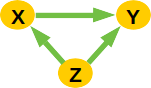

In this SCM the causal effect $p(Y|do(X=x))$ is to be interpreted as the (interventional) probability distribution of the intervened SCM where the assignment equation of $X$ is replaced:

\begin{align*}
X  &:= x \\
Y & :=  f_Y(X, Z, \eta_Y) \\
Z & :=  f_Z(\eta_Z)
\end{align*}

This mimics the experimental intervention setup. 

### Conditional causal effects

Sometimes, one may be interested in the causal effect *conditional* on values $S=s$ of another variable $S$ in the graph. The __conditional causal effect__ is denoted as

$$
p(Y|do(X=x), S=s) 
$$

and is based on the experiment of first interventionally setting $X=x$ and *then* considering the conditional interventional distribution for $S=s$.

### Multivariate causal effects

Multivariate effects for $\mathbf{X}$ on $\mathbf{Y}$ are defined accordingly. Note that one can always decompose causal effects on a multivariate $\mathbf{Y}$ into the individual effects on $Y\in\mathbf{Y}$. On the other hand, an intervention in singleton or multivariate $\mathbf{X}$ refers to two fundamentally different experiments.

### Adjustment sets

Pearl's theory allows to utilize purely graphical knowledge to employ criteria to characterize whether a causal effect of $X$ on $Y$ among observed variables $\mathbf{V}$ is *identifiable*, i.e., whether the interventional target query can be written as

\begin{align*}
p(Y|do(X=x)) = q(p(\mathbf{V}))
\end{align*}

where $q(p(\mathbf{V}))$ is some function, called the *estimand*, of the observational distribution. The general *do calculus* can be used to completely characterize when this is the case. One class of estimands is based on *backdoor adjustment* where a suitable (possibly empty) set of adjustment variables $\mathbf{Z}$ allows to express the *interventional distribution* for setting $do(X=x)$ in terms of the *observational distribution* as

$$
p(Y|do(X=x)) = \int p(Y|x,\mathbf{z}) p(\mathbf{z}) d\mathbf{z}
$$

for non-empty $\mathbf{Z}$ and as $ p(Y|do(X=x)) = p(Y|x)$ for empty $\mathbf{Z}=\emptyset$. Such a set is  called a *valid adjustment set* relative to ($X,Y$).
To repeat, the clue here is that interventional causal effects can be computed without intervention, but only based on the observational data, if the assumed graph is correct. 

Here we only consider *generalized backdoor adjustment* which yields a sufficient, but not necessary criterion to identify causal effects. To this end denote by $M$ the mediator nodes on causal paths from $X$ to $Y$ and the *forbidden nodes* as forb$(X,Y)= X\cup des(YM)$ where $des$ denotes the descendants. According to the *generalized backdoor criterion* an adjustment set $Z$ is valid if and only if both of the following conditions hold:

1. $\mathbf{Z}\cap \text{forb}=\emptyset$, and 
2. all non-causal paths  from $X$ to $Y$ are blocked by $\mathbf{Z}$. 

An adjustment set is called *minimal* if no strict subset of $\mathbf{Z}$ is still valid. 


### Optimal adjustment sets

We denote an estimator given a valid adjustment set $\mathbf{Z}$ as $\widehat{\Delta}_{yxx'|\mathbf{s}.\mathbf{z}}$. Estimators of causal effects based on such a valid adjustment set as a covariate are unbiased, but for different adjustment sets the *estimation variance* may strongly vary. An __optimal adjustment set__ may be characterized as one that has minimal asymptotic estimation variance. More formally, the task is, given a graph and $(X,Y,S)$, to chose a valid optimal set $\mathbf{Z}$ such that the causal effect estimator's asymptotic variance $\text{Var}(\widehat{\Delta}_{yxx'|\mathbf{s}.\mathbf{z}})=E[(\Delta_{yxx'|\mathbf{s}} - \widehat{\Delta}_{yxx'|\mathbf{s}.\mathbf{z}})^2]$ is minimal:

\begin{align}
\mathbf{Z}_{\rm optimal}\in {\rm argmin}_{\mathbf{Z}} \text{Var}(\widehat{\Delta}_{yxx'|\mathbf{s}.\mathbf{z}})\,.
\end{align}

The paper above derives the theory and an algorithm that characterizes the optimal adjustment $\mathbf{O}$-set and when it exists. The ``CausalEffects`` class implements this theory. If an optimal adjustment set exists, then the $\mathbf{O}$-set is optimal for *any distribution* consistent with the graph. 
For any graph the optimal set is valid if and only if a valid adjustment set exists.


## Types of graphs describing qualitative causal knowledge

### Non-time series data

Qualitative knowledge may come in different forms. For example, one may further assume that some variables in the __directed acyclic graph (DAG)__ are unobserved, here L:

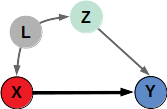

Another way to represent the presence of hidden variables is through a __acyclic directed mixed graph (ADMG)__, which would here be

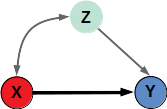

An ADMG has directed and bidirected edges representing one or more latent confounder variables.

### Time series data

In the context of time series, we consider time-dependent SCMs. An important assumption is that of stationarity, i.e., the SCM does not depend on a time point $t$. Then one may represent each variable at different instances of time as a node resulting in a __stationary DAG (statDAG)__: 

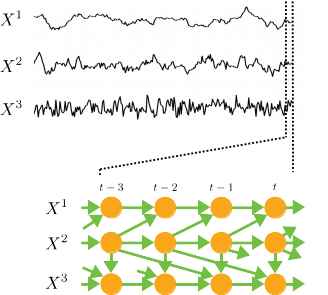

The stationarity assumption implies that this graph repeats into the past and future. Knowledge of all causal edges at time $t$ then suffices to represent all causal relations. The causal link with the maximal time lag (here 2) then defines the *order* of the process.


## Limitations of currently implemented methods

The theory of stationary time series DAGs *with hidden variables* is much more complex and currently not treated in Tigramite. However, ADMGs are treated for the non-time series case.

The theoretical results on optimal adjustment sets have so far been only established for linear least-squares estimators and singleton $X$, but the numerical results show that the $\mathbf{O}$-set or minimized variants thereof also hold for multivariate $X$ and often yield smaller variance also in non-optimal settings and for non-parametric estimators such as kNN, neural networks, gaussian processes, or random forests.



# Causal Effect class

## Initialization

``CausalEffects`` takes the following arguments:

### ``graph``, ``graph_type``, and ``hidden_variables``

``graph`` is a string array of ``dtype='<U3'`` in different shapes depending on ``graph_type``:

* ``graph_type='dag'`` denotes a non-time series DAG where ``graph`` is of shape ``(N,N)`` with N denoting the number of nodes
* ``graph_type='admg'`` denotes a non-time series ADMG where ``graph`` is of shape ``(N,N)``
* ``graph_type='stationary_dag'`` denotes a stationary time series DAG where ``graph`` is of shape ``(N,N, tau_max + 1)`` where ``tau_max`` is the maximal time lag. The ``+1`` stands for contemporaneous relations. 

``hidden_variables`` is a list of tuples ``[(k, -tau), ...]`` containing hidden variables or, for time series graphs, more generally also only selected hidden time points of a variable ``k``. For example, ``(k, -tau)`` denotes $X^k_{t-\tau}$.

In each case the entries of the graph are of ``dtype='<U3'``: 

For ``graph_type='dag'`` the edges can be ``<--`` or ``-->``. For example, with variables $(L,X,Z,Y)$ the DAG above would be given as

```
graph = np.array([['', '-->', '-->', ''],
                  ['<--', '', '', '-->'],
                  ['<--', '', '', '-->'],
                  ['', '<--', '<--', '']], dtype='<U3')
```

together with ``hidden_variables=[(0,0)]``.

As an ADMG for ``graph_type='admg'`` the edges can be ``<--``, ``-->``,  ``<->``, ``+->``, or  ``<-+``. For example, with variables $(X,Z,Y)$ it would be 

```
graph = np.array([['', '<->', '-->'],
                   ['<->', '', '-->'],
                   ['<--', '<--', '']], dtype='<U3')
```

The edge types ``+->`` and ``<-+`` represent the presence of both a directed and bidirected edge.

Note that ``hidden_variables`` can also be specified for ADMG input, then internally a modified ADMG is constructed based on the *latent projection* operation.

Finally, for ``graph_type='stationary_dag'`` the edges can be ``-->`` for time-lagged and contemporaneous links, and ``<--`` only for lag zero, i.e., in ``graph[:,:,0]``. For example, for variables $(X^1,X^2,X^3)$ the graph in the section above would be given as

```
graph =  np.array([[['', '-->', ''],
                    ['', '', ''],
                    ['', '', '']],
                   [['', '-->', ''],
                    ['', '-->', ''],
                    ['-->', '', '-->']],
                   [['', '', ''],
                    ['<--', '', ''],
                    ['', '-->', '']]], dtype='<U3')
```

For ``graph_type='stationary_dag'`` ``hidden_variables`` must be ``None`` (or empty).

In all cases, the graph must be acyclic and have consistent edges, for example, ``graph[i,j,taui,tauj]='-->'`` requires ``graph[j,i,tauj,taui]='<--'``. For the stationary DAG this is only relevant for the zero lag, i.e., in ``graph[:,:,0]``.

Internally, the ``CausalEffects`` class will convert a stationary DAG into an ADMG via a latent projection operation. In this ADMG the adjustment sets are then computed.


### ``X``,  ``Y``, and optionally  ``S``

These represent the cause variable(s) $X$, the effect variable(s) $Y$ and, optionally, the conditioning variable(s) $S$. All are lists of tuples ``[(i, -tau), ...]`` for ``tau``$\geq 0$. Given the graph, the class will check that no overlap exists, and that there actually is a causal path from $X$ to $Y$. Further, the conditions $S$ must not be in the forbidden set.

Let's start with the simple DAG with hidden variables above.

In [2]:
graph = np.array([['', '-->', '-->', ''],
                  ['<--', '', '', '-->'],
                  ['<--', '', '', '-->'],
                  ['', '<--', '<--', '']], dtype='<U3')
hidden_variables = [(0,0)]
X = [(1,0)]
Y = [(3,0)]
causal_effects = CausalEffects(graph, graph_type='dag', X=X, Y=Y, S=None, 
                               hidden_variables=hidden_variables, 
                            verbosity=1)


##
## Initializing CausalEffects class
##

Input:

graph_type = dag
X = [(1, 0)]
Y = [(3, 0)]
S = []
M = []

hidden_variables = {(0, 0)}


Internally, the DAG with hidden variables will be converted to an ADMG through the latent projection operation. Let's plot the ADMG using the ``plot_graph`` function from tigramite.plotting module. You can have a look at the docstring to see further options to change the position of nodes, coloring, etc.

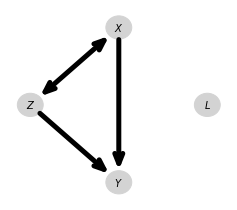

In [3]:
# Just for plotting purposes
var_names = ['$L$', '$X$', '$Z$', '$Y$']
tp.plot_graph(graph = causal_effects.graph,
        var_names=var_names, 
#         save_name='Example.pdf',
        figsize = (4, 4),
        ); plt.show()

Next we show the stationary time series DAG from above.

Setting tau_max =  5

##
## Initializing CausalEffects class
##

Input:

graph_type = stationary_dag
X = [(1, -2)]
Y = [(2, 0)]
S = []
M = [(1, 0), (2, -1), (1, -1), (2, -2)]


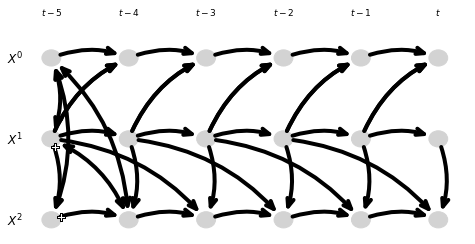

In [4]:
graph =  np.array([[['', '-->', ''],
                    ['', '', ''],
                    ['', '', '']],
                   [['', '-->', ''],
                    ['', '-->', ''],
                    ['-->', '', '-->']],
                   [['', '', ''],
                    ['<--', '', ''],
                    ['', '-->', '']]], dtype='<U3')

X = [(1,-2)]
Y = [(2,0)]
causal_effects = CausalEffects(graph, graph_type='stationary_dag', X=X, Y=Y, S=None, 
                               hidden_variables=None, 
                            verbosity=1)
var_names = ['$X^0$', '$X^1$', '$X^2$']
tp.plot_time_series_graph(graph = causal_effects.graph,
        var_names=var_names, 
#         save_name='Example.pdf',
        figsize = (8, 4),
        ); plt.show()

The graph shown is the ADMG constructed by algorithmically reconstrucing a suitable $\tau_{\max}$ (here $\tau_{\max}=5$) and then taking into account backdoor paths in the stationary DAG from time lags beyond $\tau_{\max}$.

Let's consider a more complex non-time series ADMG with multivariate $X$.

In [5]:
graph =  np.array([['', '-->', '', '', '', '', ''],
                   ['<--', '', '-->', '-->', '', '<--', ''],
                   ['', '<--', '', '-->', '', '<--', ''],
                   ['', '<--', '<--', '', '<->', '', '<--'],
                   ['', '', '', '<->', '', '<--', ''],
                   ['', '-->', '-->', '', '-->', '', ''],
                   ['', '', '', '-->', '', '', '']], dtype='<U3')

X = [(0,0), (1,0)]
Y = [(3,0)]
causal_effects = CausalEffects(graph, graph_type='admg', X=X, Y=Y, S=None, hidden_variables=None, 
                            verbosity=1)
# Just for plotting purposes
var_names = ['$X_1$', '$X_2$', '$M$', '$Y$', '$Z_1$', '$Z_2$', '$Z_3$']



##
## Initializing CausalEffects class
##

Input:

graph_type = admg
X = [(1, 0), (0, 0)]
Y = [(3, 0)]
S = []
M = [(2, 0)]


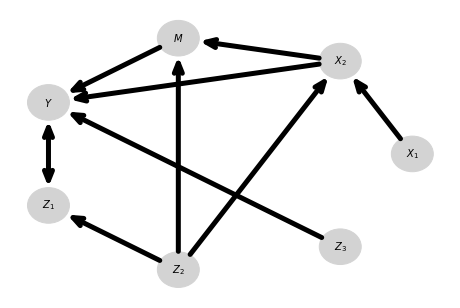

In [6]:
tp.plot_graph(graph = graph,
        var_names=var_names, 
#         save_name='Example.pdf',
        figsize = (8, 6),
        ); plt.show()

## Checks

The mediators $M$ are automatically computed from the graph. This is an ADMG since there is a bidirected edge between $Y$ and $Z_1$.

Before considering adjustment sets, we can check whether one can actually remove nodes from $\mathbf{X}$ (or $\mathbf{Y}$) that do not contribute to proper causal paths.

In [7]:
newX, newY = causal_effects.check_XYS_paths()

Consider pruning X = {(1, 0), (0, 0)} to X = {(1, 0)} since only these have causal path to Y


Here this is the case, but we will keep the original $X$ since it doesn't change the causal effect estimation.

## Adjustment sets

We could now directly move on to the ``fit_total_effect`` and ``predict_total_effect`` functions which automatically use the optimal adjustment set. But before that, we briefly discuss different possible adjustment sets.

The default implemented in the class is the $\mathbf{O}$-set. For the graph above it would be:

In [8]:
opt = causal_effects.get_optimal_set()
print("Oset = ", [(var_names[v[0]], v[1]) for v in opt])


Oset =  [('$Z_3$', 0), ('$Z_2$', 0), ('$Z_1$', 0)]


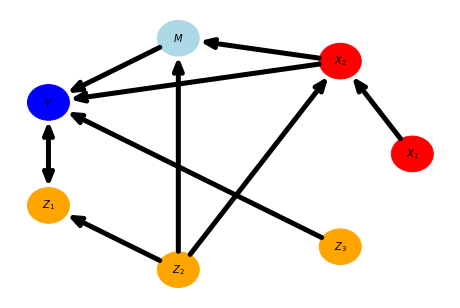

In [9]:
special_nodes = {}
for node in causal_effects.X:
    special_nodes[node] = 'red'
for node in causal_effects.Y:
    special_nodes[node] = 'blue'
for node in opt:
    special_nodes[node] = 'orange'
for node in causal_effects.M:
    special_nodes[node] = 'lightblue'

tp.plot_graph(graph = graph,
        var_names=var_names, 
#         save_name='Example.pdf',
        figsize = (8, 6),
        special_nodes=special_nodes,
        ); plt.show()

The Definition of the O-set is explained in the paper. Essentially, it consists of the parents of $Y$ and $M$ (here $Z_3,Z_2$), *valid collider paths* emanating from $YM$ (here $Y\leftrightarrow Z_1$), and the parents of these valid colliders (here $Z_2$, which is already part of the set). 

An alternative is the Adjust-set which consists of the ancestors of X and Y (and optionally S) from which forbidden nodes are removed.

In [10]:
adj = causal_effects._get_adjust_set()
print("Adjust-set = ", [(var_names[v[0]], v[1]) for v in adj])

Adjust-set =  [('$Z_3$', 0), ('$Z_2$', 0)]


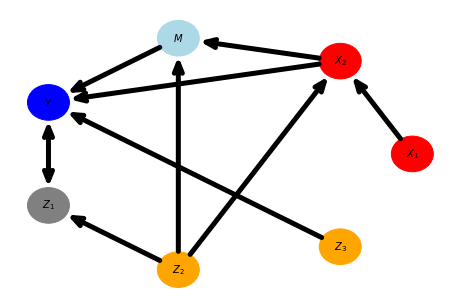

In [11]:
special_nodes = {}
for node in causal_effects.X:
    special_nodes[node] = 'red'
for node in causal_effects.Y:
    special_nodes[node] = 'blue'
for node in adj:
    special_nodes[node] = 'orange'
for node in causal_effects.M:
    special_nodes[node] = 'lightblue'

tp.plot_graph(graph = graph,
        var_names=var_names, 
#         save_name='Example.pdf',
        figsize = (8, 6),
        special_nodes=special_nodes,
        ); plt.show()

The difference to the optimal set is that the node $Z_1$ is not part of the Adjust-set. However, as studied in the paper, adding valid collider path nodes of Y and M (and their parents) to the adjustment set helps to reduce the estimators variance.

Among the theoretical contributions of the paper are theorems stating that 

1. If and only if a valid backdoor adjustment set exists, then $\mathbf{O}$-set is a valid adjustment set.
2. (Under certain conditions) the $\mathbf{O}$-set has smaller variance than the Adjust-set for any graph.
3. Whether for the tuple (graph, X, Y, S) an optimal adjustment set can exist at all (*graphical optimality holds*). If yes, then the $\mathbf{O}$-set has the smallest variance among all adjustment sets for any distribution consistent with the graph. If not, then no adjustment set has the smallest variance for any distribution. In the numerically experiments of the paper it was found, however, that even in these cases the $\mathbf{O}$-set or variants thereof are a reasonable choice.

A variant of the $\mathbf{O}$-set is the *collider-minimized* $\mathbf{O}$-set where collider nodes that do not block non-causal paths are removed. Here this would be:

Cmin-Oset =  [('$Z_3$', 0), ('$Z_2$', 0)]


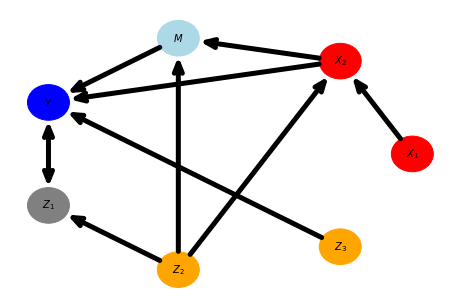

In [12]:
cminopt = causal_effects.get_optimal_set(minimize='colliders_only')
print("Cmin-Oset = ", [(var_names[v[0]], v[1]) for v in cminopt])
special_nodes = {}
for node in causal_effects.X:
    special_nodes[node] = 'red'
for node in causal_effects.Y:
    special_nodes[node] = 'blue'
for node in cminopt:
    special_nodes[node] = 'orange'
for node in causal_effects.M:
    special_nodes[node] = 'lightblue'

tp.plot_graph(graph = graph,
        var_names=var_names, 
#         save_name='Example.pdf',
        figsize = (8, 6),
        special_nodes=special_nodes,
        ); plt.show()

Here $Z_1$ is removed.

Let's check whether for this setting *graphical optimality* holds.

In [13]:
optimality = causal_effects.check_optimality()
print("(Graph, X, Y, S) fulfills optimality: ", optimality)

(Graph, X, Y, S) fulfills optimality:  True


## Estimating general total causal effects 

We now move to estimating total causal effects utilizing graphical backdoor adjustment with the optimal adjustment set.

### Ground truth toy model
First let's generate some data from an SCM with the above graph using the tigramite function ``toys.structural_causal_process`` with Gaussian unit variance noise (``noises=None``)

In [14]:
def lin_f(x): return x
coeff = .5
links_coeffs = {
                0: [], 
                1: [((0, 0), coeff, lin_f), ((5, 0), coeff, lin_f)], 
                2: [((1, 0), coeff, lin_f), ((5, 0), coeff, lin_f)],
                3: [((1, 0), coeff, lin_f), ((2, 0), coeff, lin_f), ((6, 0), coeff, lin_f), ((7, 0), coeff, lin_f)],
                4: [((5, 0), coeff, lin_f), ((7, 0), coeff, lin_f)], 
                5: [],
                6: [],
                7: [],
                }
T = 10000
data, nonstat = toys.structural_causal_process(links_coeffs, T=T, noises=None, seed=7)
dataframe = pp.DataFrame(data)

First, we plot data. This can be done with the function ``tp.plot_timeseries``

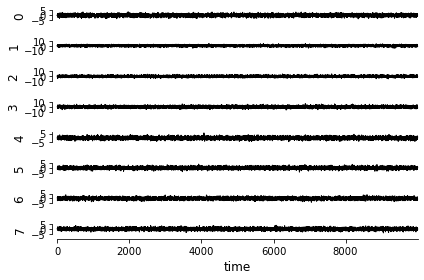

In [15]:
tp.plot_timeseries(dataframe); plt.show()

### Ground truth interventional data

Before predicting the effect of interventions, we take a look at the ground truth, which we can generate here since we have the underlying SCM.

We want to estimate the average effect of the intervention $do(X_1=x_1, X_2=x_2)$ compared to the intervention $do(X_1=x_1', X_2=x_2')$. This is the average treatment effect defined as

\begin{align*} 
 \Delta_{yxx'} = \mathbb{E}[Y|do(x)] - \mathbb{E}[Y|do(x')]\,.
\end{align*}

We now generate the interventional data for the two interventions $x_1=x_2=1$ and $x_1'=x_2'=0$

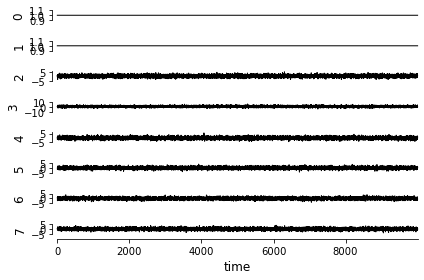

In [17]:
T = 10000
intervention1 = np.ones(T)
intervention_data1, nonstat = toys.structural_causal_process(links_coeffs, T=T, noises=None, seed=7,
                                            intervention={X[0][0]:intervention1, X[1][0]:intervention1}, 
                                            intervention_type='hard',)
tp.plot_timeseries(pp.DataFrame(intervention_data1)); plt.show()

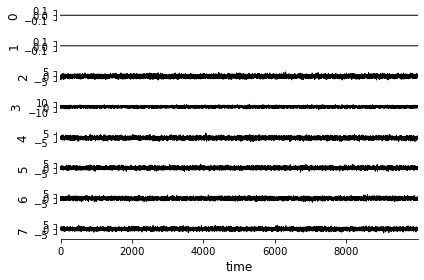

In [18]:
intervention2 = 0.*np.ones(T)
intervention_data2, nonstat = toys.structural_causal_process(links_coeffs, T=T, noises=None, seed=7,
                                            intervention={X[0][0]:intervention2, X[1][0]:intervention2}, 
                                            intervention_type='hard',)
tp.plot_timeseries(pp.DataFrame(intervention_data2)); plt.show()

The true average treatment effect is then simply the average difference of the $Y$-data:

In [19]:
true_effect = (intervention_data1[:,Y[0][0]] - intervention_data2[:,Y[0][0]]).mean()
print("True effect = %.2f" %true_effect)

True effect = 0.75


The value 0.75 here emerges as the sum of the direct causal link $X_2\to Y$ with coefficient 0.5 and the indirect path $X_2\to M \to Y$ where the effect is the product of $0.5 \times 0.5 = 0.25$.

### Fitting the causal effect adjustment model

We focus on the average treatment effect defined as

\begin{align*} 
 \Delta_{yxx'} = \mathbb{E}[Y|do(x)] - \mathbb{E}[Y|do(x')]\,.
\end{align*}

The individual terms can be estimates using an adjustment set $\mathbf{Z}$ as

\begin{align*} 
\mathbb{E}[Y|do(x)] &= \mathbb{E}_{\mathbf{Z}}\left[ \mathbb{E}_{Y|X,\mathbf{Z}}[Y|X=x, \mathbf{Z}=\mathbf{z}]\right]
\end{align*}

The approach currently implemented in this class is to estimate the inner expectation by some (here sklearn-) model $Y=\widehat{f}(X,\mathbf{Z})$ from the *observed* data for $(X, Y, \mathbf{Z})$, then evaluate $\widehat{f}(X=x,\mathbf{Z}=\mathbf{z}_t)$ at the *intervened* value $X=x$ and the *observed* values $\mathbf{Z}=\mathbf{z}_t$ and take the expectation:

\begin{align*} 
\mathbb{E}[Y|do(x)] &= \frac{1}{n} \sum_t \widehat{f}(X=x,\mathbf{Z}=\mathbf{z}_t)
\end{align*}

This is implemented in the ``fit_total_effect`` and ``predict_total_effect`` functions. The former takes as the most relevant input a ``dataframe`` and a sklearn model as an ``estimator`` object, here linear regression. The default for the ``adjustment_set`` is the optimal set. Since $S$ is empty, here we don't consider conditional causal effects. This case is discussed further below. 

Here we leave the data as it is and perform no standardization, which could be done with ``data_transform``. ``mask_type`` can be used for masking data samples (e.g., winter months).

In [16]:
causal_effects.fit_total_effect(
        dataframe=dataframe, 
        estimator=LinearRegression(),
        adjustment_set='optimal',
        conditional_estimator=None,  
        data_transform=None,
        mask_type=None,
        )

### Predicting the effect of interventions

Now we use the fitted causal effect model to predict the effect of the two interventions $x_1=x_2=1$ and $x_1'=x_2'=0$.


In [20]:
# Copy original observational data
intervention_data = data.copy()

# Set X to intervened values, first x_1'=x_2'=1
intervention_data[:,[x[0] for x in X]] = 1.
y1 = causal_effects.predict_total_effect( 
        intervention_data=pp.DataFrame(intervention_data), 
        )

# Then x_1'=x_2'=0
intervention_data[:,[x[0] for x in X]] = 0.
y2 = causal_effects.predict_total_effect( 
        intervention_data=pp.DataFrame(intervention_data), 
        )

The average treatment effect is then given by the average difference:

In [25]:
for y in Y:
    beta = (y1[y] - y2[y]).mean()
    print("Causal effect = %.2f" %(beta))


Causal effect = 0.76


As you can see, it is almost the true causal effect from above. 

As a remark, the causal effect estimate for the linear case for interventions with $x-x'=1$ is equal to the regression coefficient $\beta_{YX_2\cdot \mathbf{Z}}$ in

\begin{align*}
 Y &= \boxed{\beta_{YX_2\cdot \mathbf{Z}X_1}} X_2 + \sum_i \beta_{Y Z_i\cdot X_1X_2\mathbf{Z}\setminus Z_i} Z_i
\end{align*}

### Other estimator models

Here the ground truth is linear, so it made sense to use a linear estimator. Let's consider a nonlinear ground truth and generate observational as well interventional ground truth data for a range of intervention values.

In [22]:
def lin_f(x): return x
def nonlin_f(x): return (x + 5. * x ** 2 * np.exp(-x ** 2 / 20.))

coeff = .5
links_coeffs = {
                0: [], 
                1: [((0, 0), coeff, lin_f), ((5, 0), coeff, lin_f)], 
                2: [((1, 0), -coeff, nonlin_f), ((5, 0), coeff, lin_f)],
                3: [((1, 0), 1., nonlin_f), ((2, 0), coeff, lin_f), ((6, 0), coeff, lin_f), ((7, 0), coeff, lin_f)],
                4: [((5, 0), coeff, lin_f), ((7, 0), coeff, lin_f)], 
                5: [],
                6: [],
                7: [],
                }
# Observational data
T = 1000
data, nonstat = toys.structural_causal_process(links_coeffs, T=T, noises=None, seed=7)
dataframe = pp.DataFrame(data)

# Interventional data for a range of intervention values
intervention_values = np.linspace(-10, 10, 30)
true_causal_effects = np.zeros(len(intervention_values))
for i, int_val in enumerate(intervention_values): 
    intervention1 = int_val*np.ones(T)
    intervention_data1, nonstat = toys.structural_causal_process(links_coeffs, T=T, noises=None, seed=7,
                                            intervention={0:intervention1, 1:intervention1}, 
                                            intervention_type='hard',)
    true_causal_effects[i] = intervention_data1[:,Y[0][0]].mean()

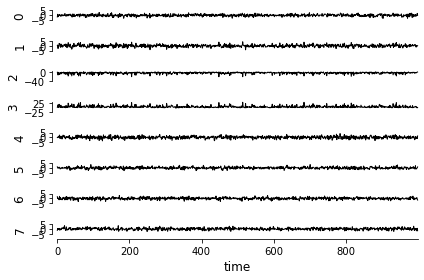

In [23]:
tp.plot_timeseries(dataframe); plt.show()

Now we fit *on the observational data* using the non-parametric ``KNeighborsRegressor()`` and then estimate the effect of the above considered interventions.

In [24]:
# Fit causal effect model from observational data
causal_effects.fit_total_effect(
        dataframe=dataframe, 
        estimator=KNeighborsRegressor(),
        adjustment_set='optimal',
        conditional_estimator=None,  
        data_transform=None,
        mask_type=None,
        )

# Predict effect of interventions
estimated_causal_effects = np.zeros(len(intervention_values))
for i, int_val in enumerate(intervention_values): 
    intervention_data = data.copy()
    # Set X to intervened values
    intervention_data[:,[x[0] for x in X]] = int_val

    result = causal_effects.predict_total_effect( 
            intervention_data=pp.DataFrame(intervention_data), 
            )
    estimated_causal_effects[i] = result[Y[0]].mean()

Below we compare the true and predicted causal effect values in $Y$ (y-axis) given intervention values in $X$ on the x-axis.

In addition, we show the observational density of $X_1$ (red).

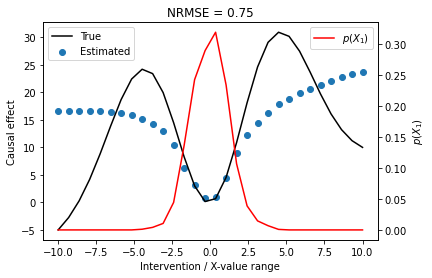

In [25]:
plt.scatter(intervention_values, estimated_causal_effects, label="Estimated")
plt.plot(intervention_values, true_causal_effects, 'k-', label="True")
plt.title(r"NRMSE = %.2f" % (np.abs(estimated_causal_effects - true_causal_effects).mean()/true_causal_effects.std()))
plt.xlabel('Intervention / X-value range')
plt.ylabel('Causal effect')
plt.legend()

# Also show observational density of X1
ax2 = plt.gca().twinx()
density = gaussian_kde(data[:,1])
ax2.plot(intervention_values, density(intervention_values), 'r-', label=r"$p(X_1)$")
ax2.set_ylabel(r'$p(X_1)$')
ax2.legend(loc='upper right')

plt.show()

The causal effect estimate works well for the range of values where the observational distribution of $X$ is non-zero. The kNN-estimator model cannot learn functional relations outside this range.

### Conditional causal effects

We now give an example application for the causal effect $p(Y|do(X=x), S=s) $ *conditional* on some values $S=s$ of another variable $S$ in the graph. 

$S$ may be a continuous variable, but here we consider the case where it is binary $\{-1, 1\}$ and defines two causal regimes:

$$
Y=0.5*S*X+Z+\eta^Y
$$

I.e., for $S=1$ we have $Y=0.5*X+Z+\eta^Y$ and for $S=-1$ we have $Y=-0.5*X+Z+\eta^Y$.

In [26]:
T = 100000

Sdata = np.random.choice([-1., 1.], size=T)
Zdata = Sdata*np.random.randn(T)
Xdata = np.random.randn(T) + Zdata
Ydata = 0.5*Sdata*Xdata + Zdata + np.random.randn(T)
data = np.vstack((Xdata, Ydata, Sdata, Zdata)).T
dataframe = pp.DataFrame(data)


##
## Initializing CausalEffects class
##

Input:

graph_type = admg
X = [(0, 0)]
Y = [(1, 0)]
S = [(2, 0)]
M = []


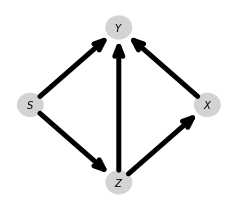

In [27]:
graph =  np.array([['', '-->', '', '<--'],
                   ['<--', '', '<--', '<--'],
                   ['', '-->', '', '-->'],
                   ['-->', '-->', '<--', '']], dtype='<U3')

X = [(0,0)]
Y = [(1,0)]
S = [(2,0)]
causal_effects = CausalEffects(graph, graph_type='admg', X=X, Y=Y, S=S, hidden_variables=None, 
                            verbosity=1)
# Just for plotting purposes
var_names = ['$X$', '$Y$', '$S$', '$Z$']
tp.plot_graph(graph = causal_effects.graph,
        var_names=var_names, 
#         save_name='Example.pdf',
        figsize = (4, 4),
        ); plt.show()

The conditional average treatment effect of the intervention $do(X=x)$ compared to the intervention $do(X=x')$ given $S=s$ is defined as follows:

\begin{align*} 
 \Delta_{yxx'|s} = \mathbb{E}[Y|do(x),s] - \mathbb{E}[Y|do(x'),s]\,.
\end{align*}

The individual terms can be estimates using the optimal adjustment set $\mathbf{O}=Z$ as

\begin{align*} 
\mathbb{E}[Y|do(x),s] &= \mathbb{E}_{Z|S}\left[ \mathbb{E}_{Y|X,Z,S}[Y|X=x, Z=z, S=s] | S=s\right]
\end{align*}

In its current implementation, these nested expectations are estimated by a nested regression where the inner expectation uses the ``estimator`` model and the outer expectation the ``conditional_estimator`` model. More specifially, the steps are:

1. Fit inner expectation $Y = f(X,Z,S)$ using the ``estimator`` model
2. Predict $(\widehat{Y}|XZS) = \widehat{f}(X=x,Z=z,S=s)$, where $z$ are the observed values, $x$ is the interventional value, and $s$ is the conditional value.
3. Fit outer expectation $\widehat{Y}|XZS = g(S)$ using the ``conditional_estimator`` model on the observational $S$
4. Predict $(\widehat{Y}|do(X=x), S=s) = \widehat{g}(S=s)$ where $s$ is the conditional value.

Here we choose a neural network for the estimator and linear regression for the conditional estimator. 

In [28]:
# Fit causal effect model from observational data
causal_effects.fit_total_effect(
        dataframe=dataframe, 
        estimator=MLPRegressor(max_iter=200),
        adjustment_set='optimal',
        conditional_estimator=LinearRegression(),  
        data_transform=None,
        mask_type=None,
        )

In [29]:
# Copy original observational data
intervention_data = data.copy()
conditions_data = data.copy()

# Set X to intervened values given S=-1, 1
# S=-1
for cond_value in [-1, 1]:
    conditions_data[:,[s[0] for s in S]] = cond_value

    intervention_data[:,[x[0] for x in X]] = 1.
    y1 = causal_effects.predict_total_effect( 
            intervention_data=pp.DataFrame(intervention_data),
            conditions_data=pp.DataFrame(conditions_data),
            )
    intervention_data[:,[x[0] for x in X]] = 0.
    y2 = causal_effects.predict_total_effect( 
            intervention_data=pp.DataFrame(intervention_data),
            conditions_data=pp.DataFrame(conditions_data),
            )
    for y in Y:
        beta = (y1[y] - y2[y]).mean()
        print("Causal effect for S = % .2f is %.2f" %(cond_value, beta))


Causal effect for S = -1.00 is -0.50
Causal effect for S =  1.00 is 0.49


This is quite well estimating the correct causal effect which for $S=1$ is $\beta=0.5$ and for $S=-1$ $\beta=-0.5$.

## Causal effects in time series DAGs

Next, we investigate causal effect estimation from the stationary DAG above.


Setting tau_max =  5

##
## Initializing CausalEffects class
##

Input:

graph_type = stationary_dag
X = [(1, -2)]
Y = [(2, 0)]
S = []
M = [(1, 0), (2, -1), (1, -1), (2, -2)]
Oset =  [('$X^1$', -3), ('$X^2$', -3), ('$X^1$', -4)]


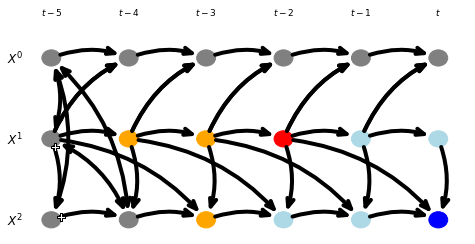

In [30]:
graph =  np.array([[['', '-->', ''],
                    ['', '', ''],
                    ['', '', '']],
                   [['', '-->', ''],
                    ['', '-->', ''],
                    ['-->', '', '-->']],
                   [['', '', ''],
                    ['<--', '', ''],
                    ['', '-->', '']]], dtype='<U3')

X = [(1,-2)]
Y = [(2,0)]
causal_effects = CausalEffects(graph, graph_type='stationary_dag', X=X, Y=Y, S=None, 
                               hidden_variables=None, 
                            verbosity=1)
var_names = ['$X^0$', '$X^1$', '$X^2$']

opt = causal_effects.get_optimal_set()
print("Oset = ", [(var_names[v[0]], v[1]) for v in opt])
special_nodes = {}
for node in causal_effects.X:
    special_nodes[node] = 'red'
for node in causal_effects.Y:
    special_nodes[node] = 'blue'
for node in opt:
    special_nodes[node] = 'orange'
for node in causal_effects.M:
    special_nodes[node] = 'lightblue'

    
tp.plot_time_series_graph(graph = causal_effects.graph,
        var_names=var_names, 
#         save_name='Example.pdf',
        figsize = (8, 4),
        special_nodes=special_nodes
        ); plt.show()

In this latent projection ADMG the optimal adjustment set is colored in orange, the mediators are in light blue. Adjustment sets and paths are considered in this ADMG. 

Let's generate some data for an SCM with the stationary DAG.

In [31]:
coeff = .5
links_coeffs = {
                0: [((0, -1), coeff, lin_f), ((1, -1), coeff, lin_f)], 
                1: [((1, -1), coeff, lin_f),], 
                2: [((2, -1), coeff, lin_f), ((1, 0), coeff, lin_f), ((1,-2), coeff, lin_f)],
                }
# Observational data
T = 1000
data, nonstat = toys.structural_causal_process(links_coeffs, T=T, noises=None, seed=7)
dataframe = pp.DataFrame(data)


Now we fit and predict the effect of the two interventions $x=1$ and $x'=0$.

In [32]:
# Fit causal effect model from observational data
causal_effects.fit_total_effect(
        dataframe=dataframe, 
        estimator=LinearRegression(),
        adjustment_set='optimal',
        )

In [33]:
# Copy original observational data
intervention_data = data.copy()

# Set X to intervened values
intervention_data[:,[x[0] for x in X]] = 1.
y1 = causal_effects.predict_total_effect( 
        intervention_data=pp.DataFrame(intervention_data), 
        )

intervention_data[:,[x[0] for x in X]] = 0.
y2 = causal_effects.predict_total_effect( 
        intervention_data=pp.DataFrame(intervention_data), 
        )

for y in Y:
    beta = (y1[y] - y2[y]).mean()
    print("Causal effect = %.2f" %(beta))


Causal effect = 0.89


In this linear model the effect is equivalent to the sum over the product of all coefficients along causal paths from $X^1_{t-2}$ to $X^2_{t}$.

## Estimating linear effects with the Wright estimator

This observation was already made by Sewall Wright in the 1920. In the following we present an alternative causal effect estimation approach that first estimates the so-called *path coefficients* for all links belonging to causal paths and then takes the sum over all causal paths of the products of these path coefficients. 

We restrict this approach to DAGs here, i.e., ``graph_type=dag``.

The estimator steps, thus, are:

1. For all causal links $i\to j$ belonging to causal paths, estimate $\beta_{i\to j}$ by regressing $j$ on its parents and taking the coefficient $\beta_{i\to j}$ belonging to parent $i$.
2. Then the causal effect is

$$
CE = \sum_{\text{causal paths}} \prod_{\text{link $i\to j$ in path}} \beta_{i\to j}
$$

We consider a DAG-version of the complex graph in the introduction.


##
## Initializing CausalEffects class
##

Input:

graph_type = dag
X = [(1, 0), (0, 0)]
Y = [(3, 0)]
S = []
M = [(2, 0)]
Oset =  [('$Z_3$', 0), ('$Z_2$', 0), ('$Z_1$', 0)]


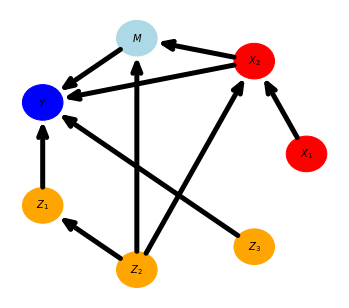

In [34]:
graph =  np.array([['', '-->', '', '', '', '', ''],
                   ['<--', '', '-->', '-->', '', '<--', ''],
                   ['', '<--', '', '-->', '', '<--', ''],
                   ['', '<--', '<--', '', '<--', '', '<--'],
                   ['', '', '', '-->', '', '<--', ''],
                   ['', '-->', '-->', '', '-->', '', ''],
                   ['', '', '', '-->', '', '', '']], dtype='<U3')

X = [(0,0), (1,0)]
Y = [(3,0)]
causal_effects = CausalEffects(graph, graph_type='dag', X=X, Y=Y, S=None, hidden_variables=None, 
                            verbosity=1)
# Just for plotting purposes
var_names = ['$X_1$', '$X_2$', '$M$', '$Y$', '$Z_1$', '$Z_2$', '$Z_3$']

opt = causal_effects.get_optimal_set()
print("Oset = ", [(var_names[v[0]], v[1]) for v in opt])
special_nodes = {}
for node in causal_effects.X:
    special_nodes[node] = 'red'
for node in causal_effects.Y:
    special_nodes[node] = 'blue'
for node in opt:
    special_nodes[node] = 'orange'
for node in causal_effects.M:
    special_nodes[node] = 'lightblue'

    
tp.plot_graph(graph = causal_effects.graph,
        var_names=var_names, 
#         save_name='Example.pdf',
        figsize = (6, 6),
        special_nodes=special_nodes
        ); plt.show()

Let's generate some data.

In [35]:
def lin_f(x): return x
coeff = .5
links_coeffs = {
                0: [], 
                1: [((0, 0), coeff, lin_f), ((5, 0), coeff, lin_f)], 
                2: [((1, 0), coeff, lin_f), ((5, 0), coeff, lin_f)],
                3: [((1, 0), coeff, lin_f), ((2, 0), coeff, lin_f), ((6, 0), coeff, lin_f), ((4, 0), coeff, lin_f)],
                4: [((5, 0), coeff, lin_f)], 
                5: [],
                6: [],
                }
T = 10000
data, nonstat = toys.structural_causal_process(links_coeffs, T=T, noises=None, seed=7)
dataframe = pp.DataFrame(data)

We fit and predict with Wright's method. Next to the data handling arguments ``fit_wrights_effect`` takes:

* ``mediated_through : list of tuples``: If None, the total effect is estimated, else only those causal paths are considerd that pass at least through one of these mediator nodes.
* ``method : {'parents', 'links_coeffs', 'optimal'}``: Method to use for estimating Wright's path coefficients. If 'optimal', the Oset is used, if 'links_coeffs', the coefficients in links_coeffs are used, if 'parents', the parents are used (only valid for DAGs).
* ``links_coeffs : dict``: Only used if method = 'links_coeffs'. Dictionary of format: {0:[((i, -tau), coeff),...], 1:[...],  ...} for all variables where i must be in [0..N-1] and tau >= 0 with number of variables N. coeff must be a float.

The default is ``method=parents`` which is suitable here since we deal with a DAG.

In [36]:
causal_effects.fit_wrights_effect(dataframe=dataframe)

intervention_data = data.copy()
# Set X to intervened values
intervention_data[:,[x[0] for x in X]] = 1.
y1 = causal_effects.predict_wrights_effect( 
        intervention_data=pp.DataFrame(intervention_data), 
        )

intervention_data[:,[x[0] for x in X]] = 0.
y2 = causal_effects.predict_wrights_effect( 
        intervention_data=pp.DataFrame(intervention_data), 
        )

for y in Y:
    beta = (y1[y] - y2[y]).mean()
    print("Causal effect = %.2f" %(beta))

Causal effect = 0.75


This is the expected result since there is one direct link with coefficient 0.5 and an indirect paths with an effect $0.5*0.5$.

Finally, the option ``mediated_through`` allows to consider only mediated effects. For the theory, please refer to Pearl (2000). Let's measure how much of the total effect is mediated through $M$.

In [37]:
considered_mediators = [(2, 0)]
causal_effects.fit_wrights_effect(dataframe=dataframe,
                                 mediated_through=considered_mediators)

intervention_data = data.copy()
# Set X to intervened values
intervention_data[:,[x[0] for x in X]] = 1.
y1 = causal_effects.predict_wrights_effect( 
        intervention_data=pp.DataFrame(intervention_data), 
        )

intervention_data[:,[x[0] for x in X]] = 0.
y2 = causal_effects.predict_wrights_effect( 
        intervention_data=pp.DataFrame(intervention_data), 
        )

for y in Y:
    beta = (y1[y] - y2[y]).mean()
    print("Mediated causal effect through M = %s is %.2f" %(considered_mediators, beta))

Mediated causal effect through M = [(2, 0)] is 0.23
